# Class for analysing effect of different modes of transport

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from math import ceil

def run_diagnostics(data, predictions, model, file_name):
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
    
    residuals = data - predictions
    plot_acf(residuals, ax=axs[0, 0])

    stats.probplot(residuals, plot=axs[0, 1])

    from statsmodels.nonparametric.smoothers_lowess import lowess

    smoothed = lowess(residuals, predictions)
    axs[1, 0].plot([0, 1], [0, 0], color = 'k',linestyle = ':', alpha = .3)
    axs[1, 0].scatter(predictions, residuals)
    axs[1, 0].plot(smoothed[:,0],smoothed[:,1],color = 'r')
    axs[1, 0].set_ylabel('Residuals')
    axs[1, 0].set_xlabel('Fitted Values')
    axs[1, 0].set_title('Residuals vs. Fitted')

    if type(model) != 'MixedLMResults':
        
        student_residuals = model.get_influence().resid_studentized_internal
        sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
        sqrt_student_residuals.index = model.resid.index
        smoothed = lowess(sqrt_student_residuals, predictions)

        axs[1, 1].scatter(predictions, sqrt_student_residuals)
        axs[1, 1].plot(smoothed[:,0],smoothed[:,1], color = 'r')
        axs[1, 1].set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
        axs[1, 1].set_xlabel('Fitted Values')
        axs[1, 1].set_title('Scale-Location')

    fig.savefig(file_name)
    
    plt.close(fig)

class Traffic:
    
    lockdown_phases = None
    transport = None
    vehicle_types = None

    figures_directory = ''
    diagnostics_directory = ''
    summary_directory = ''
    
    def __init__(self):
        
        self.import_lockdown_phases()
        self.import_transport_data()
        self.import_weather_data()
        self.set_output_directories()
        
    def set_output_directories(self, figures_directory = 'Transport/Figures/',
                               diagnostics_directory = 'Transport/Model_diagnostics/',
                               summary_directory = 'Transport/Model_summaries/'):
        
        self.figures_directory = figures_directory
        self.diagnostics_directory = diagnostics_directory
        self.summary_directory = summary_directory
    
    def import_lockdown_phases(self, extended = False):
        
        if extended:
            self.lockdown_phases = pd.DataFrame({
                'date': ['12/03/2020', '16/03/2020', '20/03/2020', '23/03/2020', '13/05/2020', '01/06/2020'],
                'event': ['self_isolation', 'work_from_home', 'restaurants_closed',
                          'national_lockdown', 'lockdown_1st_easing', 'lockdown_2nd_easing']})
        else:
            self.lockdown_phases = pd.DataFrame({
                'date': ['12/03/2020', '23/03/2020', '13/05/2020'],
                'event': ['first_restrictions', 'national_lockdown', 'lockdown_easing']})
        
        self.lockdown_phases.date = pd.to_datetime(self.lockdown_phases.date, format='%d/%m/%Y')
    
    def import_transport_data(self, file_name = 'UK_transport.csv'):
        
        self.transport = pd.read_csv(file_name)
        self.transport.Date = pd.to_datetime(self.transport.Date, format='%d/%m/%Y')
        self.vehicle_types = self.transport.columns[1:]
        self.transport["day"] = self.transport.Date.dt.day_name()
    
    def import_weather_data(self, file_name = 'UK_weather.csv'):
        
        weather = pd.read_csv(file_name)
        weather.date = pd.to_datetime(weather.date, format='%d/%m/%Y')
        weather["temperature_excess"] = weather.temperature - weather.avg_monthly_temperature_2020

        self.transport = self.transport.merge(weather, left_on='Date', right_on='date')
    
    def plot_transport_data(self):
        
        fig, ax = plt.subplots(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
        for vehicle in self.vehicle_types:
            plt.plot(self.transport.Date, self.transport[vehicle], label=vehicle.replace("_", " "))
        ax.set_ylabel('Traffic')
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.DateFormatter('%d-%b')
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.legend()
        fig.savefig(self.figures_directory + 'transport_timeline.png')
        plt.show()
        
    def plot_CO2_emissions(self):
        
        filled_transport =self.transport.interpolate().fillna(method='bfill').fillna(method='ffill')
        filled_transport["Bus"] = (filled_transport.Bus_London + filled_transport.Bus_Others) / 2

        emissions_2019 = pd.DataFrame({'vehicle': ['Cars', 'Buses', 'LCVs', 'HGVs', 'Rail'],
                                       'CO2': [69.1, 3.3, 19.3, 20.4, 2]})

        transport_emissions = pd.DataFrame({'Date': filled_transport.Date,
                                            'Cars': filled_transport.Cars * emissions_2019.CO2[0],
                                            'Buses': filled_transport.Bus * emissions_2019.CO2[1],
                                            'LCVs': filled_transport.LCV * emissions_2019.CO2[2],
                                            'HGVs': filled_transport.HGV * emissions_2019.CO2[3],
                                            'Rail': filled_transport.National_rail * emissions_2019.CO2[4]})

        fig = plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

        fig.tight_layout()
        fig.subplots_adjust(hspace=0.2)
        fig.subplots_adjust(wspace=0.3)

        ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
        ax2 = plt.subplot2grid((2, 3), (0, 2))
        ax3 = plt.subplot2grid((2, 3), (1, 2))

        ax1.stackplot(transport_emissions.Date, transport_emissions.Cars, transport_emissions.LCVs, transport_emissions.HGVs,
                     transport_emissions.Rail, transport_emissions.Buses, labels = emissions_2019.vehicle)
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.DateFormatter('%d-%b')
        ax1.xaxis.set_major_locator(locator)
        ax1.xaxis.set_major_formatter(formatter)
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles[::-1], labels[::-1])
        ax1.set_ylabel('Total CO2 emission [mln tones]')

        ax2.pie(emissions_2019.CO2, labels=emissions_2019.vehicle, autopct='%1.1f%%')
        ax2.axis('equal')
        ax2.set_title('Surface transport emissions in 2019')

        plotted_date = pd.datetime.datetime(2020, 4, 1)
        plotted_data = transport_emissions.loc[transport_emissions.Date==plotted_date].iloc[:, 1:6].to_numpy()[0]

        ax3.pie(plotted_data, labels=emissions_2019.vehicle, autopct='%1.1f%%')
        ax3.axis('equal')
        ax3.set_title('Surface transport emissions on ' + plotted_date.strftime("%d-%b-%Y"))

        fig.savefig(self.figures_directory + 'CO2_emission_timeline.png')
        plt.show()
        
    def estimate_effects(self, plotting = False, immediate = False, vehicle_types = None):
        
        if vehicle_types == None:
            vehicle_types = self.vehicle_types
        
        self.transport["base_drift"] = (self.transport.Date - self.lockdown_phases.date[0]) / np.timedelta64(1, 'D')
        self.transport["base_drift"] = self.transport["base_drift"].astype(int)
        covariates = ["intercept", "base_drift"]

        n_events = 0
        for i in range(len(self.lockdown_phases.event)):
            phase_date = self.lockdown_phases.date[i]
            phase_name = self.lockdown_phases.event[i]
            
            if i + 1 < len(self.lockdown_phases.event):
                phase_end = self.lockdown_phases.date[i + 1]
            else:
                phase_end = self.transport.Date.iloc[-1]
                
            if sum(self.transport.Date > phase_date) > 0:
                self.transport[phase_name + "_jump"] = (self.transport.Date > phase_date).astype(int)
                time_difference = ((self.transport.Date - phase_date) / np.timedelta64(1, 'D')).astype(int)
                if immediate:
                    phase_duration = self.transport[phase_name + "_jump"]
                else:
                    phase_duration = ((self.transport.Date > phase_date) & (self.transport.Date <= phase_end)).astype(int)
                self.transport[phase_name + "_drift"] = time_difference * phase_duration
                n_events = n_events + 1
                covariates = np.append(covariates, [phase_name + "_jump", phase_name + "_drift"])

        parameters_summary = pd.DataFrame(columns=np.concatenate(([i + '_mean' for i in covariates],
                                                                  [i + '_sd' for i in covariates],
                                                                  [i + '_high' for i in covariates],
                                                                  [i + '_low' for i in covariates])))
        
        grid_rows = ceil(len(vehicle_types) / 3)
        figure, axes = plt.subplots(grid_rows, 3, figsize=(15, 4 * grid_rows), dpi= 80, facecolor='w', edgecolor='k')
        x = 0
        y = 0

        for vehicle in vehicle_types:

            missing_entries = 0
            formula = vehicle + " ~ " + covariates[1]
            for var in covariates[2:]:
                n_nonzero_entries = sum(self.transport[var][np.isfinite(self.transport[vehicle])])
                if n_nonzero_entries > 0:
                    formula = formula + " + " + var
                else:
                    missing_entries = missing_entries + 1

            model = smf.ols(formula, data=self.transport, missing='drop').fit()
            
            if immediate:
                effect_name = 'immediate'
            else:
                effect_name = 'daily'
            
            file_name = self.summary_directory + 'OLS_model_' + effect_name + '_effect_summary_' + vehicle + '.csv'
            with open(file_name, 'w') as f:
                f.write(model.summary().as_csv())

            fill_cells = missing_entries * [np.nan]
            parameters = np.concatenate((model.params, fill_cells, model.bse, fill_cells,
                                         model.conf_int(alpha=0.05, cols=None)[0], fill_cells,
                                         model.conf_int(alpha=0.05, cols=None)[1], fill_cells))
            parameters = pd.DataFrame(parameters.reshape(1,-1), columns=list(parameters_summary))
            parameters_summary = parameters_summary.append(parameters, ignore_index=True)

            predictions = model.predict(self.transport)[np.isfinite(self.transport[vehicle])]
            data = self.transport[vehicle][np.isfinite(self.transport[vehicle])]
            date = self.transport["Date"][np.isfinite(self.transport[vehicle])]
            run_diagnostics(data, predictions, model, self.diagnostics_directory + vehicle + '_ILM_diagnostics.png')

            axes[x, y].plot(date, data, label="Data")
            axes[x, y].plot(date, predictions, label="Model")
            axes[x, y].set_title('Interrupted linear model (' + vehicle.replace("_", " ") + ')')
            axes[x, y].set_ylabel('Traffic')
            locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
            formatter = mdates.DateFormatter('%d-%b')
            axes[x, y].xaxis.set_major_locator(locator)
            axes[x, y].xaxis.set_major_formatter(formatter)
            axes[x, y].legend()

            y = y + 1
            if y == 3:
                y = 0
                x = x + 1
        
        while y > 0:
            axes[x, y].axis('off')
            y = y + 1
            if y == 3:
                y = 0

        if plotting:
            figure.savefig(self.figures_directory + 'interrupted_linear_model_result.png')
            plt.show()
        else:
            plt.close(figure)
        
        return parameters_summary
    
    def run_interrupted_LM(self, vehicle_types = None):
        
        immediate_effects_summary = self.estimate_effects(plotting = False, immediate = True, vehicle_types = vehicle_types)
        daily_effects_summary = self.estimate_effects(plotting = True, immediate = False, vehicle_types = vehicle_types)

        figure, axes = plt.subplots(3, 2, figsize=(16, 12), dpi= 80, facecolor='w', edgecolor='k')
        figure.tight_layout()
        figure.subplots_adjust(hspace=0.2)
        figure.subplots_adjust(wspace=0.2)

        vehicle_labels = list(map(lambda x: x.replace("_", " "), vehicle_types))

        subplot_id = 0
        for phase in self.lockdown_phases.event:
            mean = immediate_effects_summary[phase + "_jump_mean"]
            conf = np.vstack((abs(immediate_effects_summary[phase + "_jump_low"]  - mean),
                              abs(immediate_effects_summary[phase + "_jump_high"] - mean)))
            axes[subplot_id,0].errorbar(mean, vehicle_labels, xerr=conf, ls='', capsize=5, marker='o')
            axes[subplot_id,0].plot([0, 0], [vehicle_labels[0], vehicle_labels[-1]], color='grey')
            axes[subplot_id,0].set_xlabel("Immediate effect of " + phase.replace("_", " "))
            axes[subplot_id,0].set_xlim(-0.6, 0.4)
            subplot_id = subplot_id + 1

        subplot_id = 0
        for phase in self.lockdown_phases.event:
            mean = daily_effects_summary[phase + "_drift_mean"]
            conf = np.vstack((abs(daily_effects_summary[phase + "_drift_low"]  - mean),
                              abs(daily_effects_summary[phase + "_drift_high"] - mean)))
            axes[subplot_id,1].errorbar(mean, vehicle_labels, xerr=conf, ls='', capsize=5, marker='o')
            axes[subplot_id,1].plot([0, 0], [vehicle_labels[0], vehicle_labels[-1]], color='grey')
            axes[subplot_id,1].set_xlabel("Daily effect of " + phase.replace("_", " "))
            axes[subplot_id,1].set_xlim(-0.1, 0.1)
            subplot_id = subplot_id + 1
        
        figure.savefig(self.figures_directory + 'interrupted_linear_model_parameters.png')
        plt.show()
    
    def run_mixed_LM_for_bikes(self):
        
        self.transport["base_drift"] = (self.transport.Date - self.lockdown_phases.date[0]) / np.timedelta64(1, 'D')
        self.transport["base_drift"] = self.transport["base_drift"].astype(int)
        
        covariates = ["intercept", "base_drift"]

        n_events = 0
        for i in range(len(self.lockdown_phases.event)):
            phase_date = self.lockdown_phases.date[i]
            phase_name = self.lockdown_phases.event[i]
            if sum(self.transport.Date > phase_date) > 0:
                self.transport[phase_name + "_jump"] = (self.transport.Date > phase_date).astype(int)
                time_difference = ((self.transport.Date - phase_date) / np.timedelta64(1, 'D')).astype(int)
                phase_duration = self.transport[phase_name + "_jump"]
                self.transport[phase_name + "_drift"] = time_difference * phase_duration
                n_events = n_events + 1
                covariates = np.append(covariates, [phase_name + "_jump", phase_name + "_drift"])
        
        vehicle = "Cycling"

        covariates = np.append(covariates, "temperature_excess")

        missing_entries = 0
        formula = vehicle + " ~ " + covariates[1]
        for var in covariates[2:]:
            n_nonzero_entries = sum(self.transport[var][np.isfinite(self.transport[vehicle])])
            if n_nonzero_entries > 0:
                formula = formula + " + " + var
            else:
                missing_entries = missing_entries + 1

        model = smf.mixedlm(formula, self.transport, groups=self.transport.day, missing='drop').fit()
        
        linear_model = model.predict(self.transport)
        random_effects = self.transport.day.map(model.random_effects)
        random_effects = random_effects.apply(lambda x: x.values[0])
        predictions = linear_model + random_effects

        data = self.transport[vehicle]
        date = self.transport["Date"]

        fig, ax = plt.subplots(1, 2, figsize=(13, 4), dpi= 80, facecolor='w', edgecolor='k')
        fig.tight_layout()
        fig.subplots_adjust(wspace=0.4)

        ax[0].plot(date, data, label="Data")
        ax[0].plot(date, predictions, label="Model")
        ax[0].set_title('Interrupted linear model with random effects (' + vehicle + ')')
        ax[0].set_ylabel('Traffic')
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.DateFormatter('%d-%b')
        ax[0].xaxis.set_major_locator(locator)
        ax[0].xaxis.set_major_formatter(formatter)
        ax[0].legend()
        
        mean = model.params.to_numpy()[1:-1]
        conf = abs(np.transpose(model.conf_int(alpha=0.05)[1:-1].to_numpy()) - mean)
        
        ax[1].errorbar(mean, covariates[1:], xerr=conf, ls='', capsize=5, marker='o')
        ax[1].plot([0, 0], [covariates[1], covariates[-1]], color='grey')
        ax[1].set_xlabel("Effect of regulation on mobility")
        
        fig.savefig(self.figures_directory + 'mixed_linear_model_for_cycling.png')
        plt.show()

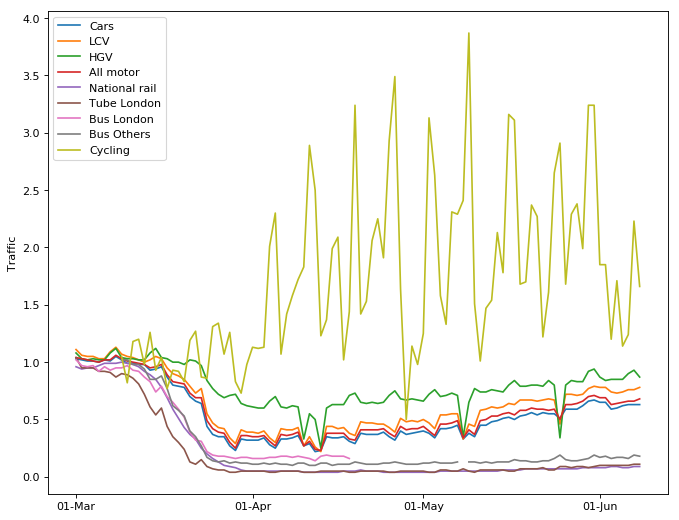

In [149]:
traffic = Traffic()
traffic.plot_transport_data()

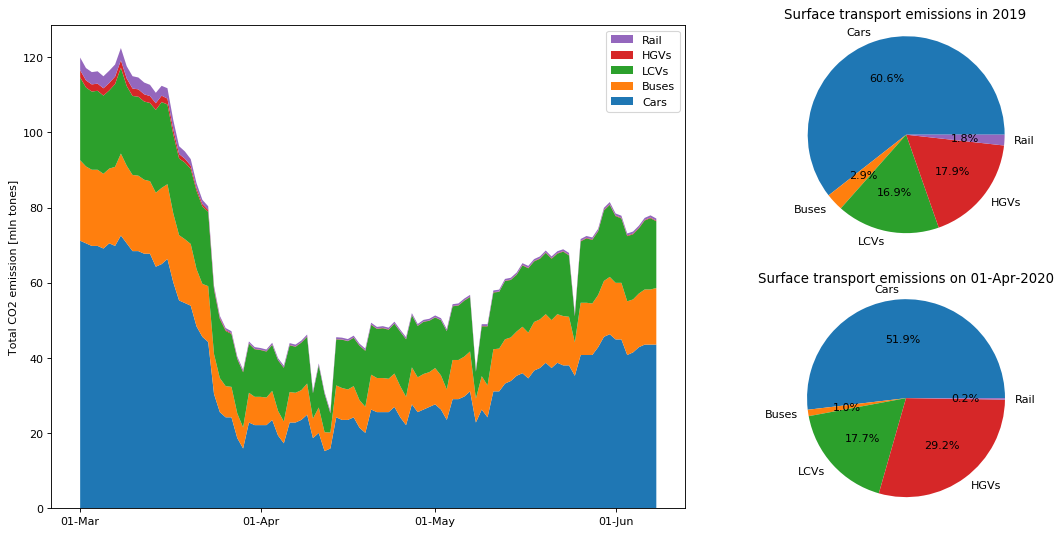

In [150]:
traffic.plot_CO2_emissions()

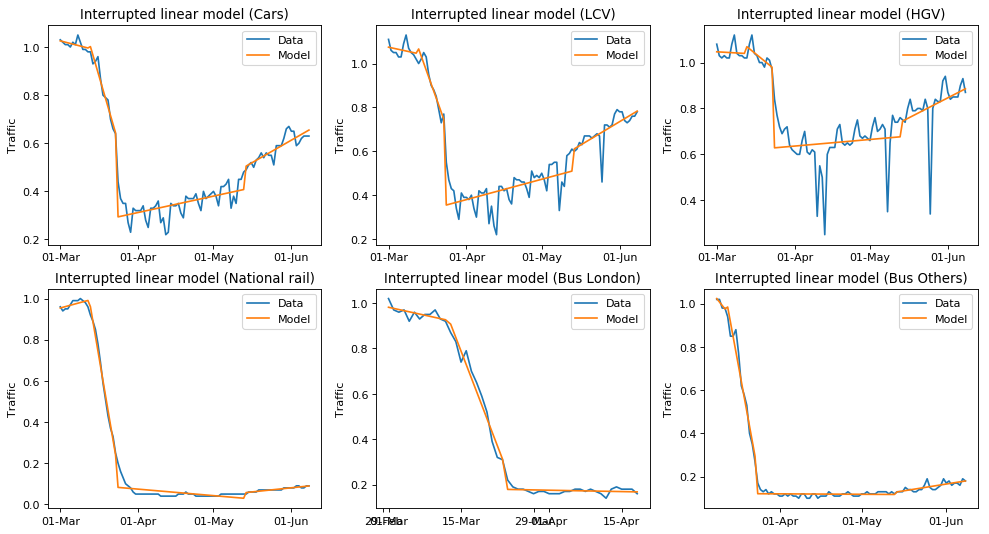

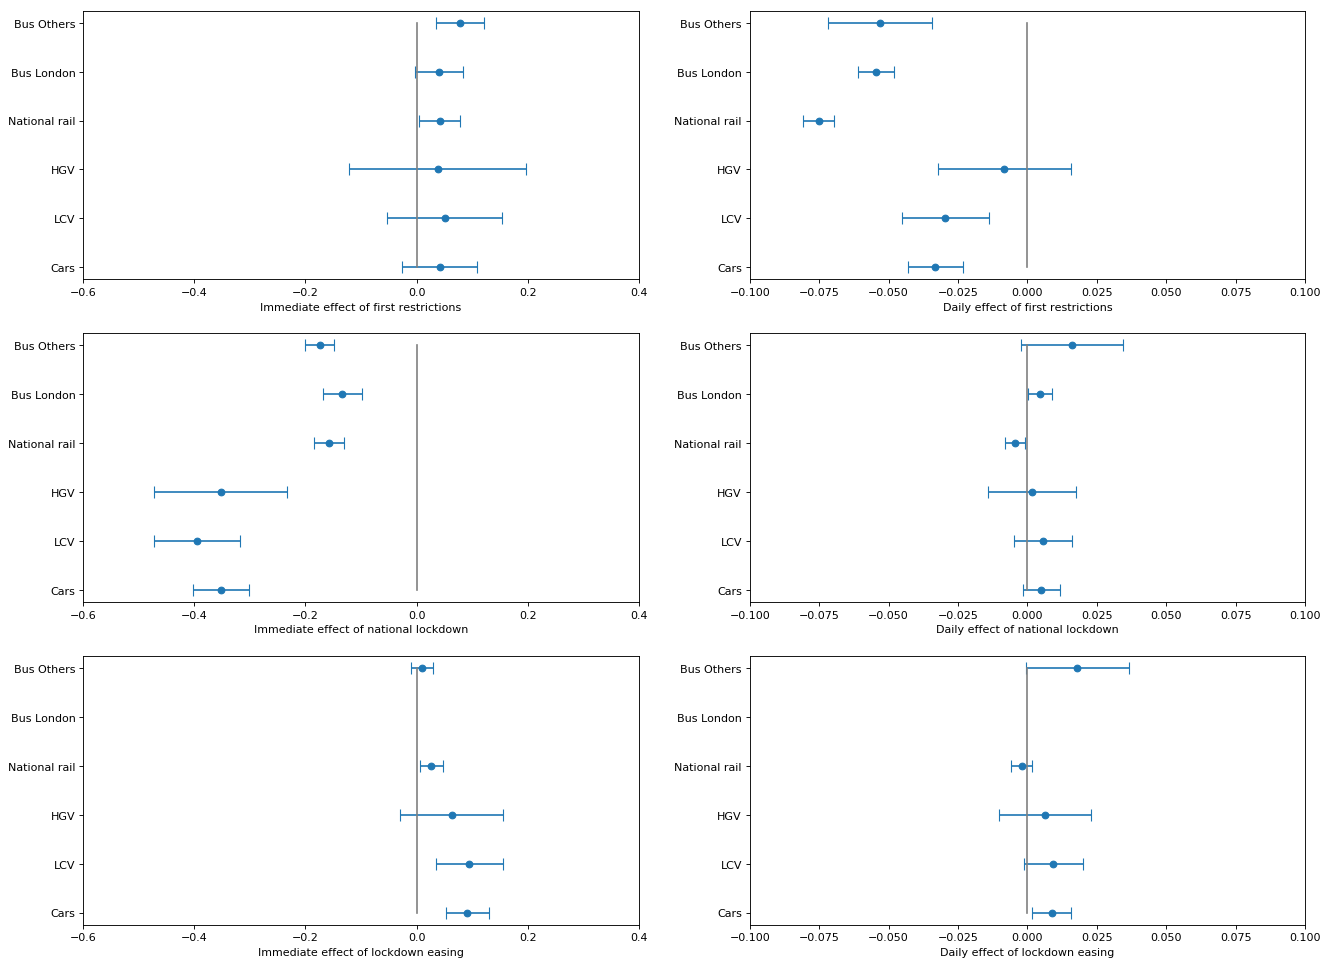

In [151]:
vehicle_types = ['Cars', 'LCV', 'HGV', 'National_rail', 'Bus_London', 'Bus_Others']
traffic.run_interrupted_LM(vehicle_types)

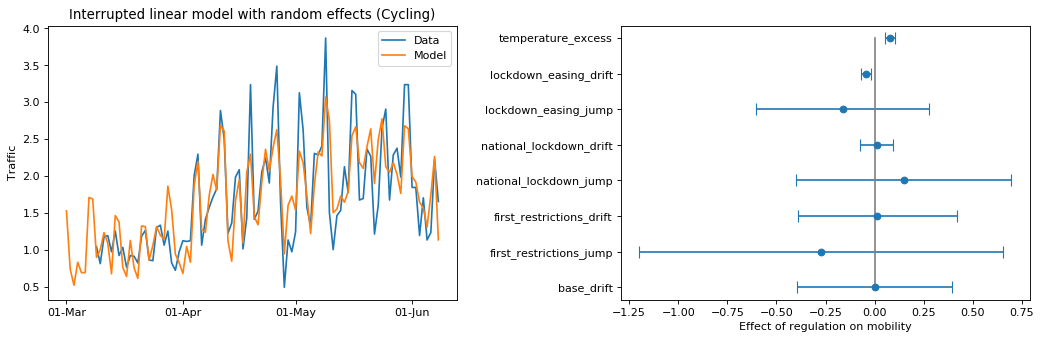

In [152]:
traffic.run_mixed_LM_for_bikes()